In [ ]:
pip install pytorch-msssim

In [ ]:
#Importing the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from torchvision import models,datasets,transforms

from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
from pytorch_msssim import ssim

In [ ]:
#Checking if a GPU with CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#Creating a custom dataset class that generates the noisy counterpart of the clean image and returns both of them
class CustomDataset(Dataset):
  def __init__(self,train_flag,sigma):
    super().__init__()
    #Defining the transforms for the train and test datasets
    train_transform = transforms.Compose([transforms.RandomRotation(45),
                                              transforms.RandomHorizontalFlip(.5),
                                              transforms.RandomVerticalFlip(.5),
                                              transforms.ToTensor()
                                              ])

    test_transform = transforms.Compose([transforms.ToTensor()])

    #Downloading the train and test datasets
    if train_flag:
      self.dataset = datasets.MNIST(root="", train = True, download=True, transform=train_transform)

    else:
      self.dataset = datasets.MNIST(root="", train = False, download=True, transform=test_transform)

    self.sigma = sigma

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    clean_img, _ = self.dataset[index]
    #Generating the noisy image
    noisy_img = (torch.randn(clean_img.shape)*(self.sigma/255.))+clean_img
    return clean_img, noisy_img



In [ ]:
#Defining a Block of the DnCNN
class Block(nn.Module):
  def __init__(self,k=3,p=1,c=64):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=c,out_channels=c,kernel_size=k,padding=p,bias=False) #same padding convolution
    self.norm = nn.BatchNorm2d(c) #batch normalization
    self.relu = nn.ReLU(inplace=True) #activation function

  def forward(self,x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.relu(x)
    return x


In [ ]:
#Defining the DnCNN model
class DCNN(nn.Module):
  def __init__(self,k=3,p=1,c=64,l=17,in_c=1):
    super().__init__()
    layers = [nn.Conv2d(in_channels=in_c,out_channels=c,kernel_size=k,padding=p,bias=False), #First same padding convolution layer
              nn.ReLU(inplace=True)]
    layers.extend([Block(k,p,c) for _ in range(l-2)]) #Adding all the "Blocks" to the model
    layers.append(nn.Conv2d(in_channels=c,out_channels=in_c,kernel_size=k,padding=p,bias=False)) #Last same padding convolution layer

    self.all = nn.Sequential(*layers)

  def forward(self,x):
    out = self.all(x)
    return x-out


In [ ]:
def test_baseline(criterion,device,test_loader):
  """
  criterion is the function used to compute PSNR
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  """

  loop = tqdm(test_loader)
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      clean_pred = torch.clamp(noisy,min=0.0,max=1.0)
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)

      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [ ]:
def test_supervised(criterion,model,device,test_loader):
  """
  criterion is the function used to compute PSNR
  model is the trained supervised DnCNN model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  """
  model.eval()
  loop = tqdm(test_loader) #Used to visualize the progress in testing
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()
      out = model(noisy)

      clean_pred = torch.clamp(out,min=0.0,max=1.0)

      #Computing PSNR
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)

      #Computing SSIM
      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")


In [ ]:
def test_unsupervised(criterion,model,device,test_loader,alpha,sigma,T):
  """
  criterion is the function used to compute PSNR
  model is the trained unsupervised denoiser model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  sigma is the noise level
  alpha is the constant of 0.5
  T is the number of forward processes averaged to reduce the effect of recorruption
  """

  model.eval()
  loop = tqdm(test_loader)  #Used to visualize the progress in testing
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      out = torch.zeros(clean.shape).to(device)
      for _ in range(T):
        noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
        noisy_main = noisy+alpha*noise
        out += model(noisy_main)

      clean_pred = torch.clamp(out/T,min=0.0,max=1.0)

      #Computing PSNR
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)
      #Computing SSIM
      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [ ]:
def display(test_set,index,model_sup,model_unsup,alpha,sigma,T):
  """
  test_set is the contains all the images of the test set
  index is a number to select an image from the test set
  model_sup is the trained supervised denoiser
  model_unsup is the trained unsupervised (R2R) denoiser
  alpha is a number
  sigma is the noise level
  T is the number of times the noisy image is passed through the unsupervised denoiser to generate clean image

  """
  clean, noisy = test_set[index]
  clean, noisy = clean.to(device), noisy.to(device)

  #For supervised Denoising
  model_sup.eval()
  out_sup = model_sup(noisy.unsqueeze(0).to(device))

  clean_pred_sup = torch.clamp(out_sup,min=0.0,max=1.0)

  #For unsupervised Denoising
  model_unsup.eval()
  out_unsup = torch.zeros(noisy.shape).unsqueeze(0).to(device)

  with torch.no_grad():
    for _ in range(T):
      noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
      noisy_main = noisy+alpha*noise
      out_unsup += model_unsup(noisy_main.unsqueeze(0))

  clean_pred_unsup = torch.clamp(out_unsup/T,min=0.0,max=1.0)

  fig,axes = plt.subplots(nrows=1, ncols=4,figsize=(20,10))

  axes[0].imshow(clean.cpu().squeeze(),cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("Ground Truth Clean Image")

  axes[1].imshow(noisy.cpu().squeeze(),cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("Noisy Image")

  axes[2].imshow(clean_pred_sup.cpu().squeeze().detach(),cmap="gray")
  axes[2].axis("off")
  axes[2].set_title("Supervised Denoised Image")

  axes[3].imshow(clean_pred_unsup.cpu().squeeze().detach(),cmap="gray")
  axes[3].axis("off")
  axes[3].set_title("Unsupervised Denoised Image")

  plt.show()

In [ ]:
criterion_test = nn.MSELoss(reduce=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#Loading all the supervised models
model_sup_10 = DCNN().to(device)
model_sup_10.load_state_dict(torch.load("/content/Supervised4_35.99_10.pt"))

model_sup_25 = DCNN().to(device)
model_sup_25.load_state_dict(torch.load("/content/Supervised3_29.84_25.pt"))

model_sup_50 = DCNN().to(device)
model_sup_50.load_state_dict(torch.load("/content/Supervised2_25.67_50.pt"))

<All keys matched successfully>

In [ ]:
#Loading all the unsupervised models
model_unsup_10 = DCNN().to(device)
model_unsup_10.load_state_dict(torch.load("/content/Unsupervised4_35.98_10.pt"))

model_unsup_25 = DCNN().to(device)
model_unsup_25.load_state_dict(torch.load("/content/Unsupervised4_29.96_25.pt"))

model_unsup_50 = DCNN().to(device)
model_unsup_50.load_state_dict(torch.load("/content/Unsupervised3_25.42_50.pt"))

<All keys matched successfully>

In [ ]:
#Defines the loaders for the train and test set
test_set_10 = CustomDataset(train_flag=False,sigma=10)
test_loader_10 = DataLoader(test_set_10,batch_size=128,shuffle=False,num_workers=128)

test_set_25 = CustomDataset(train_flag=False,sigma=25)
test_loader_25 = DataLoader(test_set_25,batch_size=128,shuffle=False,num_workers=128)

test_set_50 = CustomDataset(train_flag=False,sigma=50)
test_loader_50 = DataLoader(test_set_50,batch_size=128,shuffle=False,num_workers=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 224360045.14it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29530885.87it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78827051.88it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6131486.57it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [ ]:
test_baseline(criterion_test,device,test_loader_10)

100%|██████████| 79/79 [00:03<00:00, 23.03it/s]


 The PSNR is 30.70983123779297 and the SSIM is 0.8790203928947449


In [ ]:
test_baseline(criterion_test,device,test_loader_25)

100%|██████████| 79/79 [00:03<00:00, 22.27it/s]


 The PSNR is 22.83251953125 and the SSIM is 0.7880901098251343


In [ ]:
test_baseline(criterion_test,device,test_loader_50)

100%|██████████| 79/79 [00:03<00:00, 21.93it/s]


 The PSNR is 16.912700653076172 and the SSIM is 0.6854562759399414


In [ ]:
test_supervised(criterion_test,model_sup_10,device,test_loader_10)

100%|██████████| 79/79 [00:04<00:00, 16.36it/s]


 The PSNR is 35.9749641418457 and the SSIM is 0.9908890724182129


In [ ]:
test_supervised(criterion_test,model_sup_25,device,test_loader_25)

100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


 The PSNR is 29.854211807250977 and the SSIM is 0.977897584438324


In [ ]:
test_supervised(criterion_test,model_sup_50,device,test_loader_50)

100%|██████████| 79/79 [00:04<00:00, 16.41it/s]


 The PSNR is 25.676313400268555 and the SSIM is 0.9634179472923279


In [ ]:
test_unsupervised(criterion_test,model_unsup_10,device,test_loader_10,alpha=0.5,sigma=10,T=50)

100%|██████████| 79/79 [00:36<00:00,  2.14it/s]


 The PSNR is 35.975494384765625 and the SSIM is 0.9905848503112793


In [ ]:
test_unsupervised(criterion_test,model_unsup_25,device,test_loader_25,alpha=0.5,sigma=25,T=50)

100%|██████████| 79/79 [00:36<00:00,  2.14it/s]


 The PSNR is 29.93665313720703 and the SSIM is 0.9598236083984375


In [ ]:
test_unsupervised(criterion_test,model_unsup_50,device,test_loader_50,alpha=0.5,sigma=50,T=50)

100%|██████████| 79/79 [00:37<00:00,  2.13it/s]


 The PSNR is 25.417247772216797 and the SSIM is 0.9482941627502441


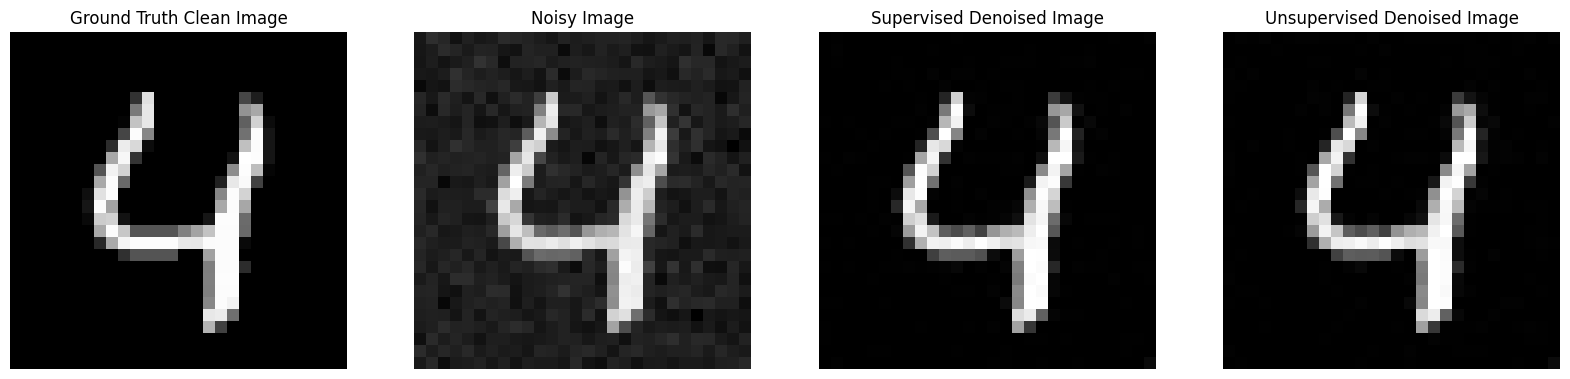

In [ ]:
display(test_set_10,index=4,model_sup=model_sup_10,model_unsup=model_unsup_10,alpha=0.5,sigma=10,T=50)

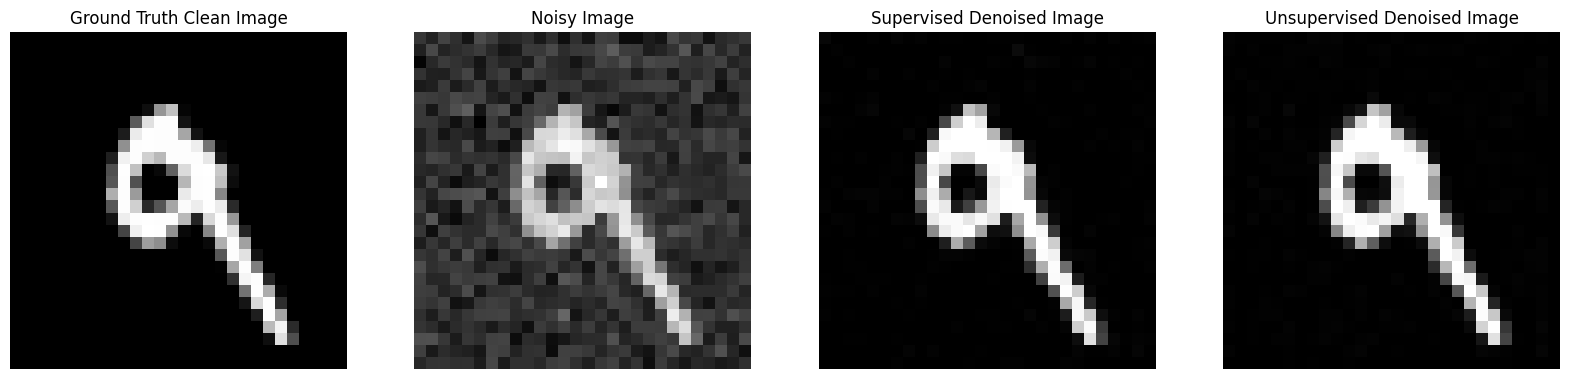

In [ ]:
display(test_set_25,index=7,model_sup=model_sup_25,model_unsup=model_unsup_25,alpha=0.5,sigma=25,T=50)

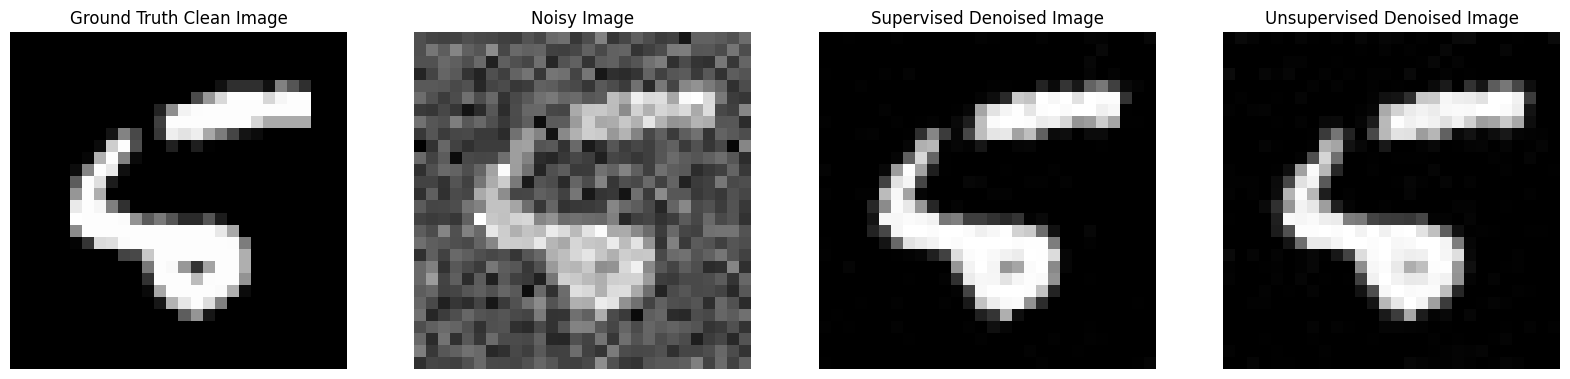

In [ ]:
display(test_set_50,index=8,model_sup=model_sup_50,model_unsup=model_unsup_50,alpha=0.5,sigma=50,T=50)